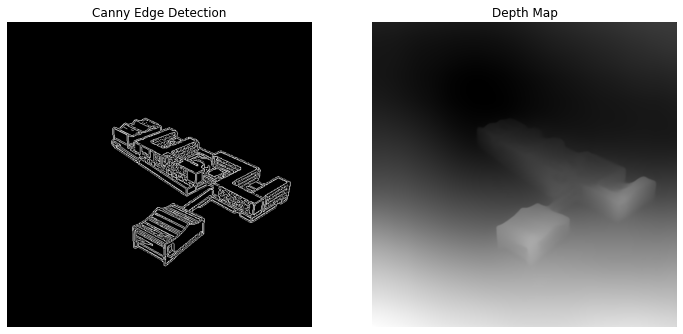

In [3]:
import torch
import numpy as np
from PIL import Image
from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, AutoencoderKL
from diffusers.utils import load_image
import cv2
import numpy as np
from PIL import Image
from diffusers.utils import load_image

original_image = load_image(
    "/home/athiwat/progressive_img2sketch/resources/LOD_combined_sketches_best_i_think/3/lod2/lod2_az225_el30.png"
)

image = np.array(original_image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

depth_image = get_depth_map(image)

#show canny and depth images with matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Canny Edge Detection")
plt.imshow(canny_image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Depth Map")
plt.imshow(depth_image, cmap='gray')
plt.axis('off')
plt.show()



100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


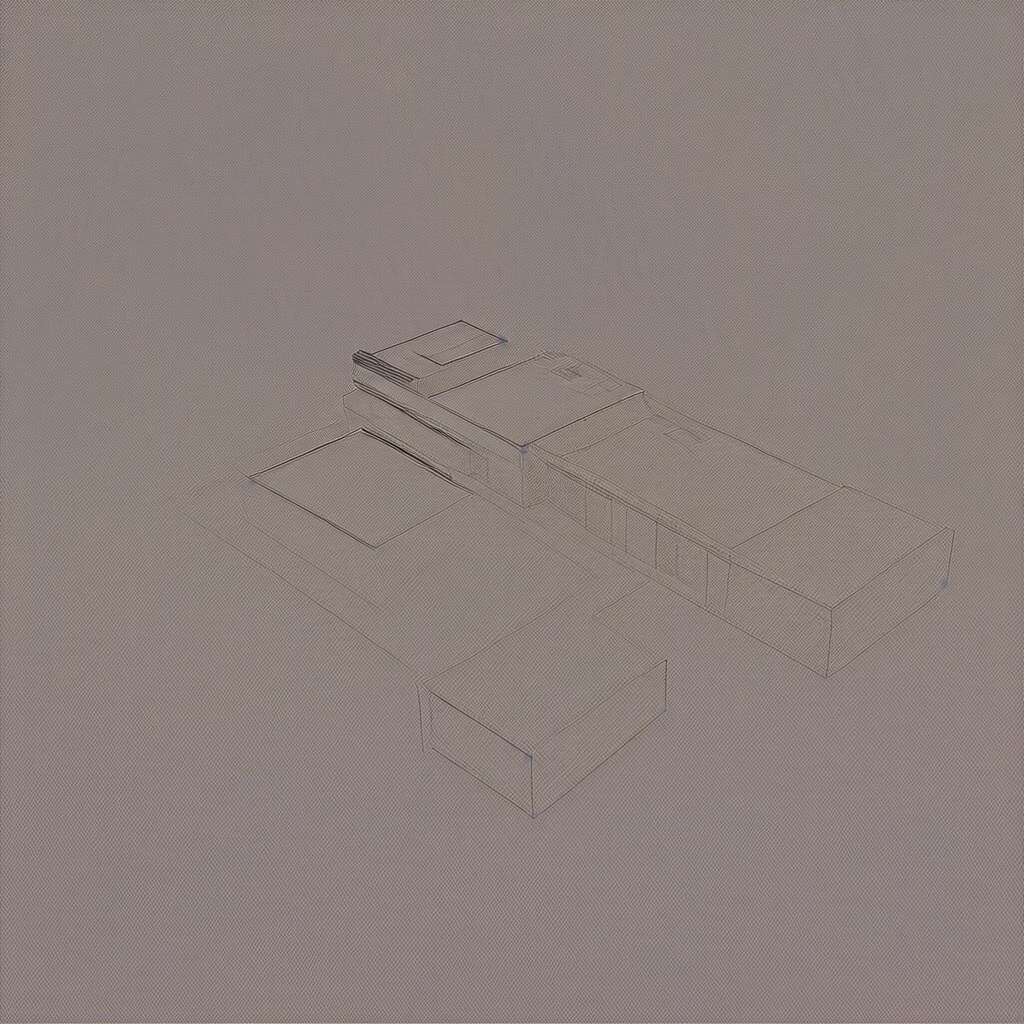

In [7]:
import torch
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL

controlnets = [
    ControlNetModel.from_pretrained(
        "diffusers/controlnet-depth-sdxl-1.0-small", torch_dtype=torch.float16
    ),
    ControlNetModel.from_pretrained(
        "diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16,
    ),
]

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnets, vae=vae, torch_dtype=torch.float16
).to("cuda")

prompt = """
A simplified building shoebox, with a flat roof and no windows, in a minimalist style.
white background, black lines. with correct geometry, perspective, and proportions.
"""
negative_prompt = "lowres, bad anatomy, worst quality, low quality, deformed, ugly"

images = [canny_image.resize((1024, 1024)), depth_image.resize((1024, 1024))]

pipeline(
    prompt,
    negative_prompt=negative_prompt,
    image=images,
    num_inference_steps=100,
    controlnet_conditioning_scale=[1.0, 0.5],
    strength=0.7,
).images[0]